In [1]:
from scipy.io import wavfile
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import os
import seaborn as sns
import random
import sys
import scipy.spatial.distance as scipydt
from numpy.linalg import inv
from scipy.spatial import distance
from tqdm import tqdm
from scipy.stats import multivariate_normal

In [2]:
img = plt.imread('im0.ppm')
left_img = img

In [3]:
img2 = plt.imread('im8.ppm')
right_img = img2

In [4]:
d_matrix=np.zeros((381,390))

In [5]:
for i in range(len(right_img)):
    row_selection=right_img[i,:]
    for j in range (len(left_img[0])-40):
        dist=np.argmin(distance.cdist([row_selection[j]], left_img[i,j:j+40], 'euclidean')[0])
        d_matrix[i][j]=dist

In [6]:
reshaped_matrix_d=np.reshape(d_matrix,(1,381*390))

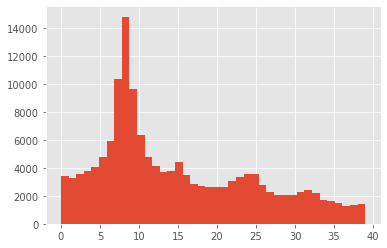

In [7]:
plt.style.use('ggplot')
plt.hist(reshaped_matrix_d[0], bins=40)
plt.show()

Text(0.5, 1.0, 'Histogram')

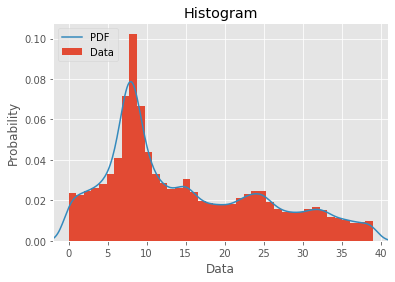

In [8]:
import scipy.stats as st
plt.hist(reshaped_matrix_d[0], density=True, bins=40, label="Data")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 301)
kde = st.gaussian_kde(reshaped_matrix_d[0])
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")
plt.ylabel('Probability')
plt.xlabel('Data')
plt.title("Histogram")

From the graph we can see that there exists 4 clusters visible by the peaks

In [9]:
n_gaussians=4

## Intialising prior probailities
prior_probability=np.ones(n_gaussians)*(1/n_gaussians)

disparity=reshaped_matrix_d[0]

In [10]:
## Intializing means
means=[6,15,23,32]
print(means)

##Intializing sigma
sigma=np.random.uniform(0,20,n_gaussians)

##Intializing likelihood(probability of data point given cluster)
L=np.zeros([len(disparity),n_gaussians])

## Inialising posterior probabilities
U=np.zeros([len(disparity),n_gaussians])

[6, 15, 23, 32]


In [11]:
np.random.uniform(0,1,1)[0]

0.553131736519039

In [12]:
iterations=10000
for iter in tqdm(range(iterations)):
    
    
    mu_previous,sigma_previous=means.copy(),sigma.copy()
    
    for i in range(n_gaussians):
        
        L[:,i]=multivariate_normal.pdf(disparity,mu_previous[i],sigma_previous[i])
        
    
    ### Normalisation
    
    P_normalise= np.sum(prior_probability*L,axis=1)
    
    U= prior_probability*L/P_normalise.reshape(-1,1)
    
    ## M_step
    
    prior_probability=np.mean(U,axis=0)
    
    for k in range(n_gaussians):
        
        means[k]= np.dot(U[:,k],disparity)/np.sum(U[:,k])
        sigma[k]=np.sum(U[:,k]*(disparity-means[k])**2)/np.sum(U[:,k])
    
    
    if np.array_equal(np.round(means, 7), np.round(mu_previous, 7)) and np.array_equal(np.round(sigma, 7),np.round(sigma_previous, 7)):
        break

 20%|██        | 2050/10000 [00:40<02:27, 53.84it/s]

In [13]:
sd=np.argmax(U,axis=1)
sd1=[]
for i in range(len(sd)):
    sd1.append(means[sd[i]])

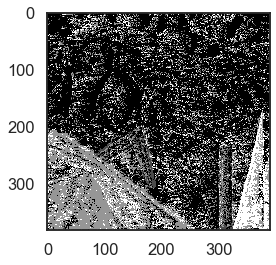

In [14]:
GMM_matrix=np.reshape(sd1,(381,390))
sns.set(style="white", context="talk")
plt.imshow(GMM_matrix,cmap='gray')
plt.savefig('GMM.png')
plt.show()

In [15]:
print(means)

[7.431572762567511, 15.393872843888945, 23.290659925036852, 34.32177543230622]


In [16]:
def neighbors(data,x, y):
    if x==0 and y==0:
        return np.array([data[x, y+1],data[x+1, y+1],data[x+1, y]])
    if x==380 and y==0:
        return np.array([data[x-1, y],data[x-1, y+1],data[x, y+1]])
    if x==0 and y==389:
        return np.array([data[x, y-1],data[x+1, y-1],data[x+1, y]])
    if x==380 and y==389:
        return np.array([data[x-1, y],data[x-1, y-1],data[x, y-1]])
    if x == 0:
        return np.array([data[x, y+1],data[x, y-1],data[x+1, y-1],data[x+1, y],data[x+1, y+1]])
    if x == 380:
        return np.array([data[x, y+1],data[x, y-1],data[x-1, y-1],data[x-1, y],data[x-1, y+1]])
    if y == 0:
        return np.array([data[x-1, y],data[x+1, y],data[x-1, y+1],data[x, y+1],data[x+1, y+1]])
    if y == 389:
        return np.array([data[x-1, y],data[x+1, y],data[x-1, y-1],data[x, y-1],data[x+1, y-1]])
    else:
        return np.array([data[x-1, y-1],data[x-1, y],data[x-1, y+1],data[x, y-1],data[x, y+1],data[x+1, y-1],data[x+1, y],data[x+1, y+1]])

In [17]:
initialmeans=GMM_matrix.copy()
assigned_class=np.reshape(sd,(381,390))

In [18]:
def Cumulative(lists):  
    cu_list = []  
    length = len(lists)  
    cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)]  
    return cu_list[1:]

In [19]:
no_of_iteration=30
a=5
class_list = []
for reps in tqdm(range(no_of_iteration)):
    new_class=[]

    for i in range(len(initialmeans)): 
        
        for j in range(len(initialmeans[0])):
            
            index = i *initialmeans.shape[1] + j
            
            Nei_class=neighbors(assigned_class,i,j)
            
            list_ofP_neighbors=[]
            
            for k in range(4):
            
                z = list(np.equal(k, Nei_class))

                f_c = np.array([0 if x == True else a for x in z])

                P_c = np.exp(np.negative(np.square(f_c)))

                P_c_nei = np.prod(P_c)
                
                list_ofP_neighbors.append(P_c_nei)   

            x = L[index, :]
            
            P_c_x = np.array(x) * np.array(list_ofP_neighbors)
            
            P_c_x_sum = np.sum(P_c_x)
            
            P_c_x = P_c_x / P_c_x_sum
            
            random_number=np.random.uniform(0,1,1)[0]
            
            p_c_x_sort=np.sort(P_c_x)
            
            cumulativelist= Cumulative(p_c_x_sort)
            
            for l in range(len(cumulativelist)):
                if random_number<=cumulativelist[l]:
                    index1=l
                    break
                else:
                    l=l+1
            index2=np.argsort(P_c_x)
            
            final_class=index2[index1]
            
            new_class.append(final_class)
            
    class_list.append(new_class)
    new_class1 = np.array(new_class)
    new_class2 = new_class1.reshape((381, 390))
    assigned_class = new_class2.copy()            


100%|██████████| 30/30 [09:24<00:00, 18.82s/it]


In [20]:
gh1=np.array(class_list)

In [21]:
final_list_Gibbs=[]
for kl in range (len(gh1[0])):
    counts = np.bincount(np.array(gh1[:,kl]))
    final_list_Gibbs.append(np.argmax(counts))

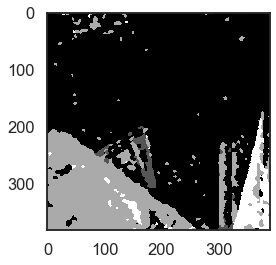

In [22]:
GMM_matrix1=np.reshape(final_list_Gibbs,(381,390))
sns.set(style="white", context="talk")
plt.imshow(GMM_matrix1,cmap='gray')
plt.savefig('Gibbs.png')
plt.show()